In [1]:
experiment_name = 'Patients with ICD code AND notes for sepsis'

In [2]:
import json
import os
import random
import sys
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pandas.io.sql as psql
import psycopg2 as pg
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm, trange

from nfold_roc_auc import plot_roc_auc

%matplotlib inline
random.seed(42)
np.random.seed(42)
os.environ['PYTHONHASHSEED'] = "42"
connection = pg.connect("host=localhost dbname=MIMIC-III user=postgres password=1027")


In [3]:
queries = json.load(open("queries.json"))


In [4]:
all_patients = psql.read_sql("SELECT subject_id, hadm_id\nFROM diagnoses_icd", connection)

p1_patients = psql.read_sql(queries['patients'], connection)
p2_patients = pd.read_csv("cluster_0.csv")
patients = p1_patients.merge(p2_patients, on='subject_id', how='inner')[['subject_id']]
patients = patients.merge(all_patients, on='subject_id', how='inner')

patients = patients.sort_values(by=['subject_id', 'hadm_id'])
patients = patients.groupby('subject_id').last().reset_index()
patients

,subject_id,hadm_id
0,21,111970
1,62,116009
2,64,172056
3,145,198161
4,157,110545
...,...,...
1536,99469,189343
1537,99726,186684
1538,99740,161687
1539,99822,195871


In [5]:
df = patients.sort_values(by=['subject_id', 'hadm_id'])
df = df.groupby('subject_id').last().reset_index()
df = df.merge(pd.read_csv('patients.csv').drop('subject_id', axis=1), on='hadm_id', how='left')
df

,subject_id,hadm_id,gender,age,admission_type,marital_status,icustay_id,icd9_code,systolic,diastolic,...,lactate,calcium,anion gap,los,admittime,deathtime,delta_deathtime,mortality_30,mortality_60,mortality_90
0,21,111970,0.0,87.753232,1.0,2,216859.0,NaN,98.176471,36.764706,...,NaN,7.700000,15.000000,8.3647,2135-01-30 20:50:00,2135-02-08 02:08:00,8 days 05:18:00,1.0,1.0,1.0
1,62,116009,0.0,68.711877,1.0,2,216609.0,7140,97.545455,56.909091,...,2.100000,7.833333,10.000000,2.8257,2113-02-15 00:19:00,NaN,NaN,0.0,0.0,0.0
2,64,172056,1.0,26.656789,1.0,1,232593.0,7895,109.444444,57.388889,...,NaN,NaN,10.500000,2.3250,2143-03-03 09:25:00,NaN,NaN,0.0,0.0,0.0
3,145,198161,1.0,54.946125,1.0,1,246376.0,E9342,126.000000,56.814815,...,1.125000,9.100000,14.000000,47.4385,2144-03-29 01:44:00,NaN,NaN,0.0,0.0,0.0
4,157,110545,0.0,80.395503,1.0,1,235058.0,NaN,120.000000,55.964286,...,NaN,7.900000,14.000000,2.0621,2106-05-17 10:59:00,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,99469,189343,0.0,66.575409,1.0,2,209410.0,NaN,NaN,NaN,...,NaN,9.300000,12.333333,2.0902,2181-10-16 16:02:00,NaN,NaN,0.0,0.0,0.0
1537,99726,186684,0.0,60.982976,1.0,2,299571.0,NaN,124.965517,71.068966,...,13.521429,7.533333,35.333333,2.6455,2200-11-24 00:46:00,2200-11-26 14:07:00,2 days 13:21:00,1.0,1.0,1.0
1538,99740,161687,0.0,51.260119,1.0,2,269160.0,NaN,NaN,NaN,...,NaN,7.466667,15.000000,8.5399,2135-05-01 18:12:00,2135-05-17 15:25:00,15 days 21:13:00,1.0,1.0,1.0
1539,99822,195871,0.0,61.251472,1.0,2,297672.0,NaN,108.250000,77.583333,...,2.900000,7.833333,15.333333,4.1091,2197-07-03 02:24:00,2197-07-08 13:15:00,5 days 10:51:00,1.0,1.0,1.0


In [6]:
XY = df[['age', 'asparate aminotransferase', 'mcv', 'alanine aminotransferase', 'urea nitrogen', 'partial prothrombin time', 'prothrombin time', 'rcv', 'lactate', 'albumin', 'total bilirubin', 'mortality_30', 'mortality_60', 'mortality_90']]
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
0,87.753232,82.0,99.000000,47.0,50.000000,43.50,19.100000,17.700000,NaN,2.10,0.30,1.0,1.0,1.0
1,68.711877,NaN,93.750000,NaN,20.250000,32.00,13.600000,13.575000,2.100000,NaN,NaN,0.0,0.0,0.0
2,26.656789,60.0,79.000000,323.0,13.500000,29.70,12.900000,14.200000,NaN,NaN,1.70,0.0,0.0,0.0
3,54.946125,35.0,84.500000,76.0,15.250000,32.10,14.400000,14.000000,1.125000,3.50,0.70,0.0,0.0,0.0
4,80.395503,NaN,89.000000,NaN,6.000000,33.10,14.000000,16.400000,NaN,NaN,NaN,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1536,66.575409,18.0,92.666667,24.0,27.666667,24.70,12.200000,14.233333,NaN,NaN,0.30,0.0,0.0,0.0
1537,60.982976,298.0,99.000000,143.0,61.666667,39.00,17.366667,15.833333,13.521429,2.00,4.40,1.0,1.0,1.0
1538,51.260119,309.0,82.000000,407.5,17.666667,52.15,42.400000,14.700000,NaN,3.60,21.45,1.0,1.0,1.0
1539,61.251472,NaN,87.500000,NaN,19.666667,NaN,NaN,16.200000,2.900000,NaN,NaN,1.0,1.0,1.0


In [7]:
XY.isnull().sum()

age                           99
asparate aminotransferase    638
mcv                          145
alanine aminotransferase     639
urea nitrogen                140
partial prothrombin time     391
prothrombin time             372
rcv                          145
lactate                      629
albumin                      842
total bilirubin              642
mortality_30                  99
mortality_60                  99
mortality_90                  99
dtype: int64

In [8]:
XY = XY.dropna(thresh=len(XY.columns)-1)
XY.isnull().sum()

age                            0
asparate aminotransferase      1
mcv                            0
alanine aminotransferase       0
urea nitrogen                  0
partial prothrombin time       4
prothrombin time               1
rcv                            0
lactate                      147
albumin                      157
total bilirubin                2
mortality_30                   0
mortality_60                   0
mortality_90                   0
dtype: int64

In [9]:
XY.fillna(XY.mean(), inplace=True)
XY

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin,mortality_30,mortality_60,mortality_90
0,87.753232,82.000000,99.0,47.000000,50.000000,43.500000,19.100000,17.700000,2.975840,2.10,0.300000,1.0,1.0,1.0
3,54.946125,35.000000,84.5,76.000000,15.250000,32.100000,14.400000,14.000000,1.125000,3.50,0.700000,0.0,0.0,0.0
7,68.825983,46.000000,91.0,57.000000,67.666667,30.450000,13.700000,13.000000,1.300000,3.20,1.100000,0.0,0.0,0.0
8,23.850487,22.500000,79.0,8.000000,5.666667,37.233333,13.766667,18.500000,1.533333,1.90,0.366667,1.0,1.0,1.0
10,76.763182,166.000000,100.5,367.500000,63.000000,76.066667,19.800000,15.950000,2.975840,2.90,0.650000,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,48.483465,4305.666667,84.4,1647.666667,102.800000,40.200000,20.137500,15.900000,5.663636,2.30,7.033333,1.0,1.0,1.0
1535,87.733972,194.000000,93.5,304.500000,15.500000,37.050000,16.900000,13.750000,1.300000,2.90,2.150000,0.0,0.0,0.0
1537,60.982976,298.000000,99.0,143.000000,61.666667,39.000000,17.366667,15.833333,13.521429,2.00,4.400000,1.0,1.0,1.0
1538,51.260119,309.000000,82.0,407.500000,17.666667,52.150000,42.400000,14.700000,2.975840,3.60,21.450000,1.0,1.0,1.0


Text(0.5, 1.01, 'Patients with ICD code AND notes for sepsis')

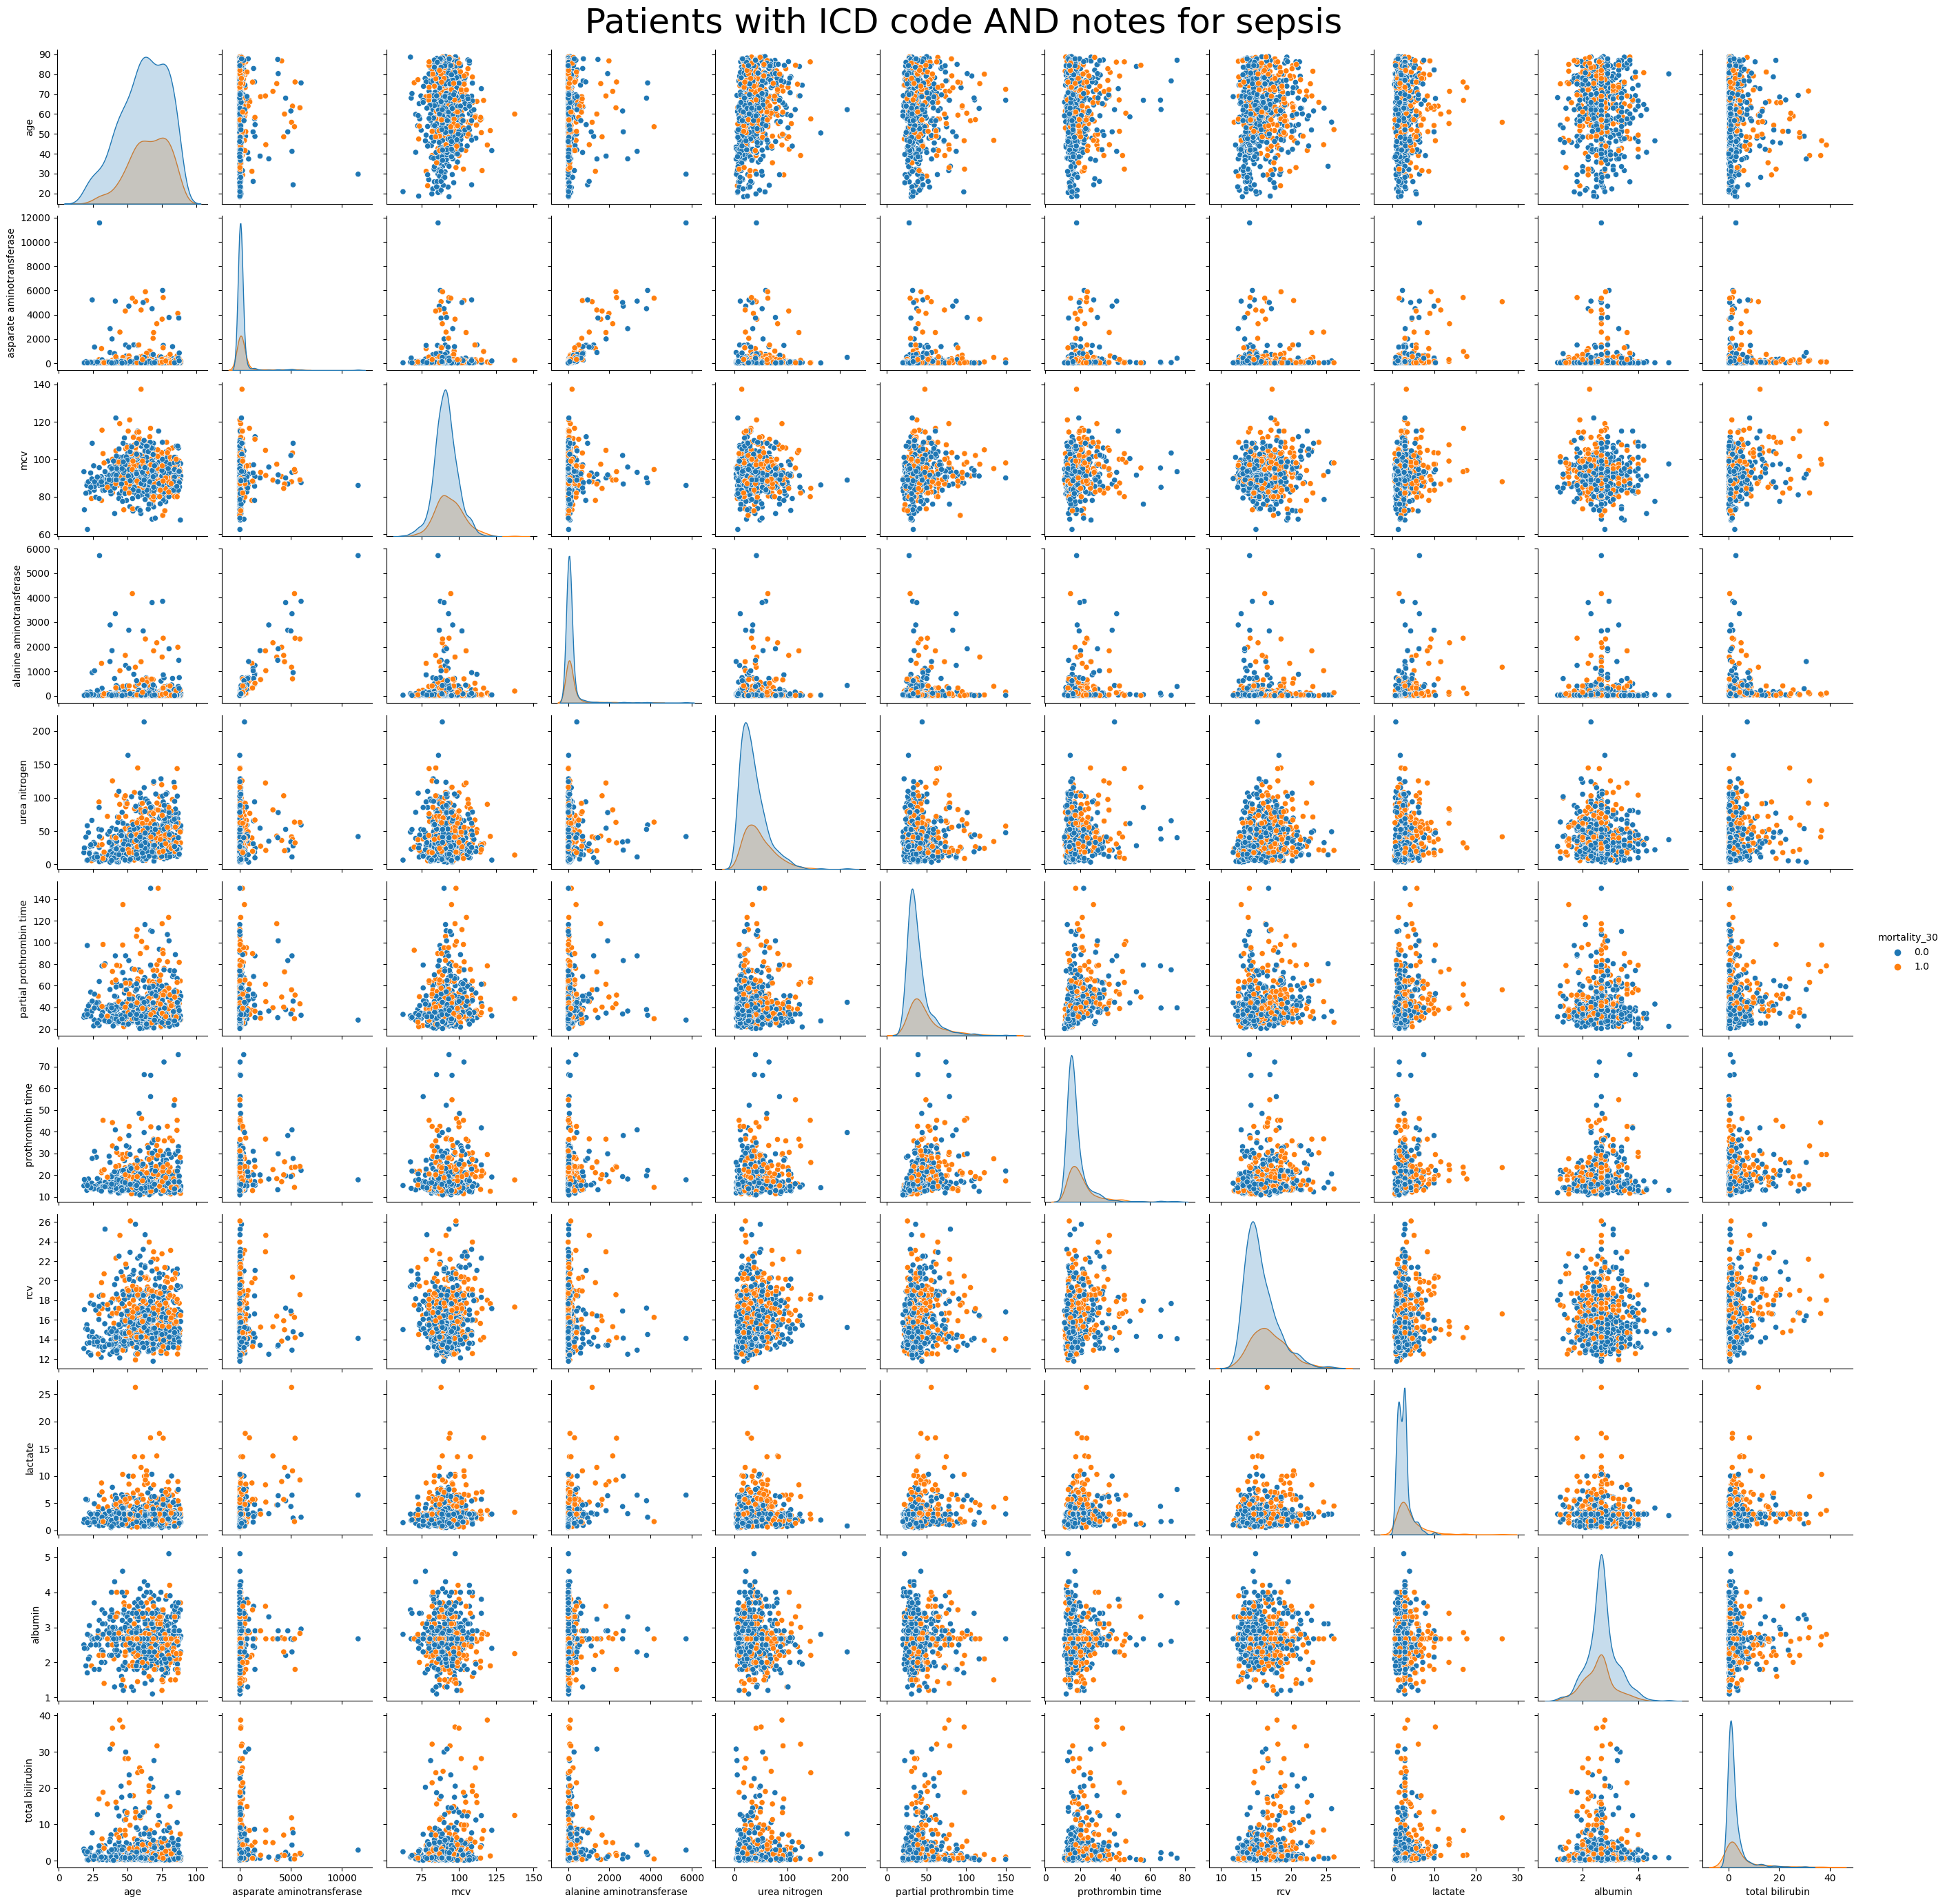

In [10]:
g = sns.pairplot(XY[XY.columns.to_list()[:-2]], hue='mortality_30')
g.fig.suptitle(experiment_name, fontsize=36, y=1.01)

In [11]:
X = XY.drop(["mortality_30", "mortality_60", "mortality_90"], axis=1)
y = XY["mortality_30"]
y_60 = XY["mortality_60"]
y_90 = XY["mortality_90"]
X
X

,age,asparate aminotransferase,mcv,alanine aminotransferase,urea nitrogen,partial prothrombin time,prothrombin time,rcv,lactate,albumin,total bilirubin
0,87.753232,82.000000,99.0,47.000000,50.000000,43.500000,19.100000,17.700000,2.975840,2.10,0.300000
3,54.946125,35.000000,84.5,76.000000,15.250000,32.100000,14.400000,14.000000,1.125000,3.50,0.700000
7,68.825983,46.000000,91.0,57.000000,67.666667,30.450000,13.700000,13.000000,1.300000,3.20,1.100000
8,23.850487,22.500000,79.0,8.000000,5.666667,37.233333,13.766667,18.500000,1.533333,1.90,0.366667
10,76.763182,166.000000,100.5,367.500000,63.000000,76.066667,19.800000,15.950000,2.975840,2.90,0.650000
...,...,...,...,...,...,...,...,...,...,...,...
1534,48.483465,4305.666667,84.4,1647.666667,102.800000,40.200000,20.137500,15.900000,5.663636,2.30,7.033333
1535,87.733972,194.000000,93.5,304.500000,15.500000,37.050000,16.900000,13.750000,1.300000,2.90,2.150000
1537,60.982976,298.000000,99.0,143.000000,61.666667,39.000000,17.366667,15.833333,13.521429,2.00,4.400000
1538,51.260119,309.000000,82.0,407.500000,17.666667,52.150000,42.400000,14.700000,2.975840,3.60,21.450000


In [12]:
y

0       1.0
3       0.0
7       0.0
8       1.0
10      1.0
       ... 
1534    1.0
1535    0.0
1537    1.0
1538    1.0
1540    0.0
Name: mortality_30, Length: 730, dtype: float64

In [13]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [14]:
# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[103  71]
 [ 44 129]]
              precision    recall  f1-score   support

         0.0       0.70      0.59      0.64       174
         1.0       0.65      0.75      0.69       173

    accuracy                           0.67       347
   macro avg       0.67      0.67      0.67       347
weighted avg       0.67      0.67      0.67       347



In [15]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.582857142857143 	 0.020559079185640868
F1         0.5324866273382348 	 0.03713537067605458
Recall     0.4780952380952382 	 0.0550077298216901
Precision  0.6059950197579657 	 0.02851329343033287


{'fit_time': array([0.75899959, 0.37000084, 0.45300055, 0.45000005, 1.29799914]),
 'score_time': array([0.00400043, 0.00200057, 0.0040009 , 0.00299978, 0.00199986]),
 'test_accuracy': array([0.56666667, 0.55238095, 0.60952381, 0.59047619, 0.5952381 ]),
 'train_accuracy': array([0.59285714, 0.59642857, 0.58571429, 0.59642857, 0.5952381 ]),
 'test_f1': array([0.54726368, 0.46590909, 0.56382979, 0.56565657, 0.51977401]),
 'train_f1': array([0.57035176, 0.51778094, 0.54210526, 0.55801825, 0.53678474]),
 'test_recall': array([0.52380952, 0.39047619, 0.5047619 , 0.53333333, 0.43809524]),
 'train_recall': array([0.54047619, 0.43333333, 0.49047619, 0.50952381, 0.46904762]),
 'test_precision': array([0.57291667, 0.57746479, 0.63855422, 0.60215054, 0.63888889]),
 'train_precision': array([0.6037234 , 0.64310954, 0.60588235, 0.6167147 , 0.62738854])}

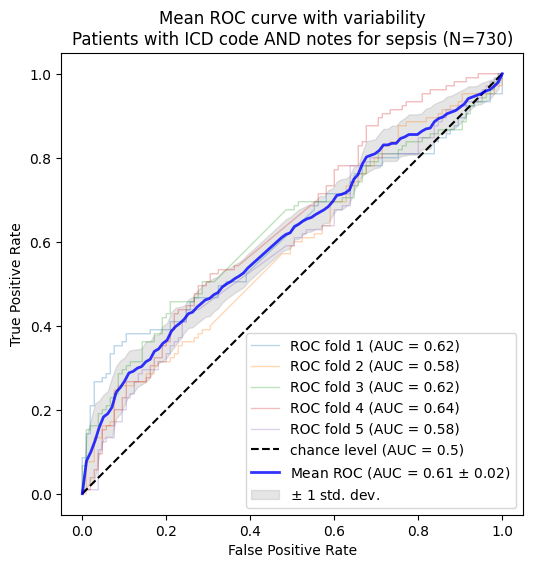

In [16]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [17]:
grid = [
    {
        'activation': ['logistic', 'tanh', 'relu'],
        'alpha': [0.0001, 0.0005, 0.001, 0.005],
        'learning_rate_init': [0.0005, 0.001, 0.005, 0.01],
        'hidden_layer_sizes': [(5), (10), (20), (5, 5), (10, 10), (20, 20)]
     }
]

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

grid_search.best_params_


Fitting 5 folds for each of 288 candidates, totalling 1440 fits


{'activation': 'relu',
 'alpha': 0.0001,
 'hidden_layer_sizes': (20, 20),
 'learning_rate_init': 0.01}

In [18]:
# fine-tuned MLP
mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


[[124  50]
 [ 37 136]]
              precision    recall  f1-score   support

         0.0       0.77      0.71      0.74       174
         1.0       0.73      0.79      0.76       173

    accuracy                           0.75       347
   macro avg       0.75      0.75      0.75       347
weighted avg       0.75      0.75      0.75       347



In [19]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.6 	 0.04994327848429292
F1         0.5616927332670907 	 0.21445612415976167
Recall     0.6361904761904762 	 0.3003490033436499
Precision  0.6253220620521759 	 0.06716419814454339


{'fit_time': array([0.27599955, 0.2379992 , 0.20299983, 0.24699736, 0.48700142]),
 'score_time': array([0.00300074, 0.00300336, 0.00299859, 0.00300312, 0.00399876]),
 'test_accuracy': array([0.58095238, 0.64761905, 0.66190476, 0.52380952, 0.58571429]),
 'train_accuracy': array([0.61904762, 0.63095238, 0.61309524, 0.5297619 , 0.63690476]),
 'test_f1': array([0.65625   , 0.6185567 , 0.72156863, 0.13793103, 0.6741573 ]),
 'train_f1': array([0.68503937, 0.57063712, 0.68538238, 0.15053763, 0.71941122]),
 'test_recall': array([0.8       , 0.57142857, 0.87619048, 0.07619048, 0.85714286]),
 'train_recall': array([0.82857143, 0.49047619, 0.84285714, 0.08333333, 0.93095238]),
 'test_precision': array([0.55629139, 0.6741573 , 0.61333333, 0.72727273, 0.55555556]),
 'train_precision': array([0.58389262, 0.68211921, 0.57748777, 0.77777778, 0.5862069 ])}

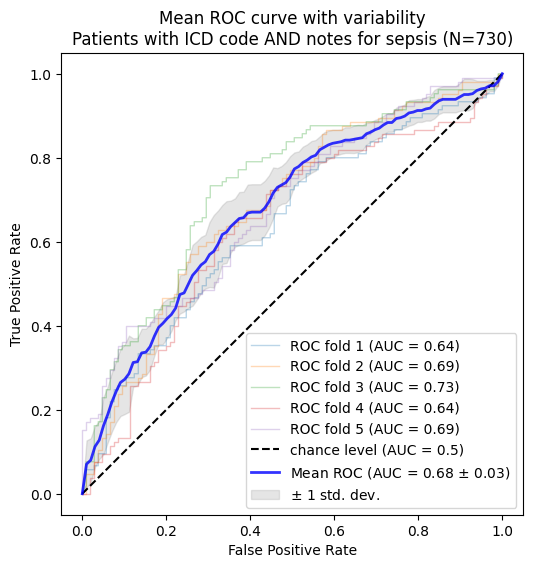

In [20]:
plot_roc_auc(mlp, X_res, y_res, experiment_name, len(XY))

In [21]:
# Oversample the data
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X.values, y_60.values)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, stratify=y_res, test_size=0.33, random_state=42)

# Scale the data
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

grid_search = GridSearchCV(estimator=MLPClassifier(random_state=42), param_grid=grid, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

print('best params', grid_search.best_params_)

mlp = MLPClassifier(
    hidden_layer_sizes=grid_search.best_params_["hidden_layer_sizes"],
    random_state=42,
    activation=grid_search.best_params_["activation"],
    alpha=grid_search.best_params_["alpha"],
    learning_rate_init=grid_search.best_params_["learning_rate_init"],
)

# MLP
mlp = MLPClassifier(hidden_layer_sizes=(5), random_state=42)
mlp.fit(X_train, y_train)

predictions = mlp.predict(X_test)

print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))


Fitting 5 folds for each of 288 candidates, totalling 1440 fits
best params {'activation': 'logistic', 'alpha': 0.005, 'hidden_layer_sizes': (10, 10), 'learning_rate_init': 0.005}
[[111  56]
 [ 43 123]]
              precision    recall  f1-score   support

         0.0       0.72      0.66      0.69       167
         1.0       0.69      0.74      0.71       166

    accuracy                           0.70       333
   macro avg       0.70      0.70      0.70       333
weighted avg       0.70      0.70      0.70       333



In [22]:
# Cross validation
cv_results = cross_validate(mlp, X_res, y_res, cv=5, scoring=['accuracy', 'f1', 'recall', 'precision'], return_train_score=True)
print('Accuracy  ', cv_results['test_accuracy'].mean(), '\t', cv_results['test_accuracy'].std())
print('F1        ', cv_results['test_f1'].mean(), '\t', cv_results['test_f1'].std())
print('Recall    ', cv_results['test_recall'].mean(), '\t', cv_results['test_recall'].std())
print('Precision ', cv_results['test_precision'].mean(), '\t', cv_results['test_precision'].std())
cv_results

Accuracy   0.5238559676863208 	 0.025933336208038393
F1         0.4498451995485021 	 0.024038598785716573
Recall     0.39083168316831685 	 0.04142674591292
Precision  0.5377908781785925 	 0.03970708226392222


{'fit_time': array([0.71799898, 0.29899907, 0.3340013 , 0.52399659, 0.31100035]),
 'score_time': array([0.00200081, 0.0040009 , 0.00400186, 0.00300145, 0.00300097]),
 'test_accuracy': array([0.53960396, 0.49009901, 0.4950495 , 0.54228856, 0.55223881]),
 'train_accuracy': array([0.52109181, 0.54466501, 0.52977667, 0.54894672, 0.55018587]),
 'test_f1': array([0.48618785, 0.43093923, 0.46315789, 0.41772152, 0.45121951]),
 'train_f1': array([0.45014245, 0.49098474, 0.50457516, 0.42586751, 0.47467438]),
 'test_recall': array([0.43564356, 0.38613861, 0.43564356, 0.32673267, 0.37      ]),
 'train_recall': array([0.39205955, 0.43920596, 0.47890819, 0.33498759, 0.40594059]),
 'test_precision': array([0.55      , 0.4875    , 0.49438202, 0.57894737, 0.578125  ]),
 'train_precision': array([0.52842809, 0.55660377, 0.53314917, 0.58441558, 0.57142857])}

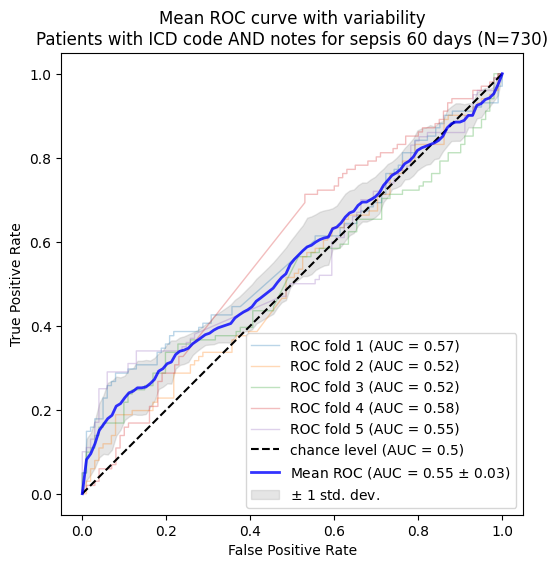

In [23]:
plot_roc_auc(mlp, X_res, y_res, experiment_name + ' 60 days', len(XY))